<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Logistic Regression

_Authors: Kiefer Katovich (SF), Matt Brems (DC)_

---

### Learning Objectives
- Distinguish between regression and classification problems.
- Understand how logistic regression is similar to and different from linear regression.
- Plot the logistic regression for predicting admittance from GPA.
- Fit, generate predictions from, and evaluate a logistic regression model in `sklearn`.
- Understand how to interpret the coefficients of logistic regression.
- Know the benefits of logistic regression as a classifier.

<a id='introduction'></a>

## Introduction

---

Logistic regression is a natural bridge to connect regression and classification.
- Logistic regression is the most common binary classification algorithm.
- Because it is a regression model, logistic regression will predict continuous values.
    - Logistic regression will predict continuous probabilities between 0 and 1.
    - Example: What is the probability that someone shows up to vote?
- However, logistic regression almost always operates as a classification model.
    - Logistic regression will use these continuous predictions to classify something as 0 or 1.
    - Example: Based on the predicted probability, do we predict that someone votes?

In this lecture, we'll only be reviewing the binary outcome case with two classes, but logistic regression can be generalized to predicting outcomes with 3 or more classes.

**Some examples of when logistic regression could be used:**
- Will a user will purchase a product, given characteristics like income, age, and number of family members?
- Does this patient have a specific disease based on their symptoms?
- Will a person default on their loan?
- Is the iris flower in front of me an "_Iris versicolor_?"
- Given one's GPA and the prestige of a college, will a student be admitted to a specific graduate program?

And many more.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import LogisticRegression and LinearRegression from sklearn.linear_model
from sklearn.linear_model import LogisticRegression, LinearRegression

## Graduate School Admissions

---

Today, we'll be applying logistic regression to solve the following problem: "Given one's GPA, will a student be admitted to a specific graduate program?"

In [2]:
# Read in the data.
admissions = pd.read_csv('../data/admissions.csv')

In [3]:
# Check first five rows.
admissions.head()

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0
3,1,640.0,3.19,4.0
4,0,520.0,2.93,4.0


The four columns are:
- `admit`: A binary 0/1 variable indicating whether or not a student was admitted, where 1 means admitted and 0 means not admitted.
- `gre`: The student's [GRE (Graduate Record Exam)](https://en.wikipedia.org/wiki/Graduate_Record_Examinations) score.
- `gpa`: The student's GPA.
- `prestige`: A 1-4 rating for the college's "prestige."

In [4]:
# How many missing values do we have in each column?
admissions.isnull().sum()

admit       0
gre         2
gpa         2
prestige    1
dtype: int64

In [5]:
# Drop every row that has an NA.
admissions.dropna(inplace=True)

<details><summary>What assumption are we making when we drop rows that have at least one NA in it?</summary>
    
- We assume that what we drop looks like what we have observed. That is, there's nothing special about the rows we happened to drop.
- We might say that what we dropped is a random sample of our whole data.
- It's not important to know this now, but the formal term is that our data is missing completely at random.
</details>

<details><summary>Suppose I want to check if a value of 1 for prestige means "most prestigious" or "least prestigious." How might I find this out?</summary>
    
- Check a data dictionary to see if the answer exists.
- If a data dictionary doesn't exist, compare prestige to admit. You could use [groupby](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.DataFrame.groupby.html) to make a table or you could use a plot.
</details>

In [6]:
# Find the mean prestige score of people who were and weren't admitted.
admissions.groupby(by='admit')['prestige'].mean()

admit
0    2.645756
1    2.150794
Name: prestige, dtype: float64

### Artificially increase the signal in the data.

The signal for detecting admission in the college data is fairly weak — too weak for the purposes of our demonstration. (There are lots of factors associated with getting admitted to grad school other than GPA, test score, and prestige.)

**Obviously you would never do this to your real data**... but in order to make the relationship between our predictors and whether or not someone is admitted a lot clearer, we are making 10 copies of the data set and adding an artificial signal for detecting `admit` to the `gpa` column.

In [7]:
# Grab all rows where prestige = 1.
admit = admissions[admissions['prestige'] == 1]

# Concatenate ten copies of admit.
admit = pd.concat([admit] * 10, axis=0)

# Set a random seed.
np.random.seed(42)

# Add random noise to inflate GPA for people who were admitted.
# Subtract random noise to deflate GPA for people who were not admitted.
# Again: DO NOT DO THIS IN GENERAL.
admit.loc[admit['admit'] == 1, 'gpa'] += np.random.random(size=admit[admit.admit == 1].shape[0])
admit.loc[admit['admit'] == 0, 'gpa'] -= np.random.random(size=admit[admit.admit == 0].shape[0])

## Recap of Notation

You're quite familiar with **linear** regression:

### $$
\begin{eqnarray*}
\hat{Y} &=& \hat{\beta}_0 + \hat{\beta}_1X_1 + \hat{\beta}_2X_2 + \cdots + \hat{\beta}_pX_p \\
&=& \hat{\beta}_0 + \sum_{j=1}^p\hat{\beta}_jX_j
\end{eqnarray*}
$$

Where:
- $\hat{Y}$ is the predicted value of $Y$ based on all of the inputs $X_j$.
- $X_1$, $X_2$, $\ldots$, $X_p$ are the predictors.
- $\hat{\beta}_0$ is the estimated intercept.
- $\hat{\beta}_j$ is the estimated coefficient for the predictor $X_j$, the $j$th column in variable matrix $\mathbf{X}$.


<a id='pred-admit'></a>

## What If We Predicted `admit` With `gpa` Using Linear Regression?

Let's try predicting the `admit` binary indicator using just `gpa` with a linear regression to see what goes wrong.

In [8]:
# Define y and X.
y = admit['admit']
X = admit[['gpa']] # Because X is usually a matrix, we'll get a 
                   # reshape request if we don't use double brackets.


# Import train_test_split.
from sklearn.model_selection import train_test_split

# Create training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=42)

# Instantiate a linear regression model.
linmod = LinearRegression()

# Fit our linear regression model to the training data.
linmod.fit(X_train, y_train)

# Print out intercept and coefficients.
print(f'Intercept: {linmod.intercept_}')
print(f'Coefficient: {linmod.coef_}')

Intercept: -1.225475968212868
Coefficient: [0.50623083]


<a id='plot-reg'></a>
### What do those coefficients mean?  Plot `admit` (our $Y$) against `gpa` (our $X$).

Looking at the plot below, what are problems with using a regression?

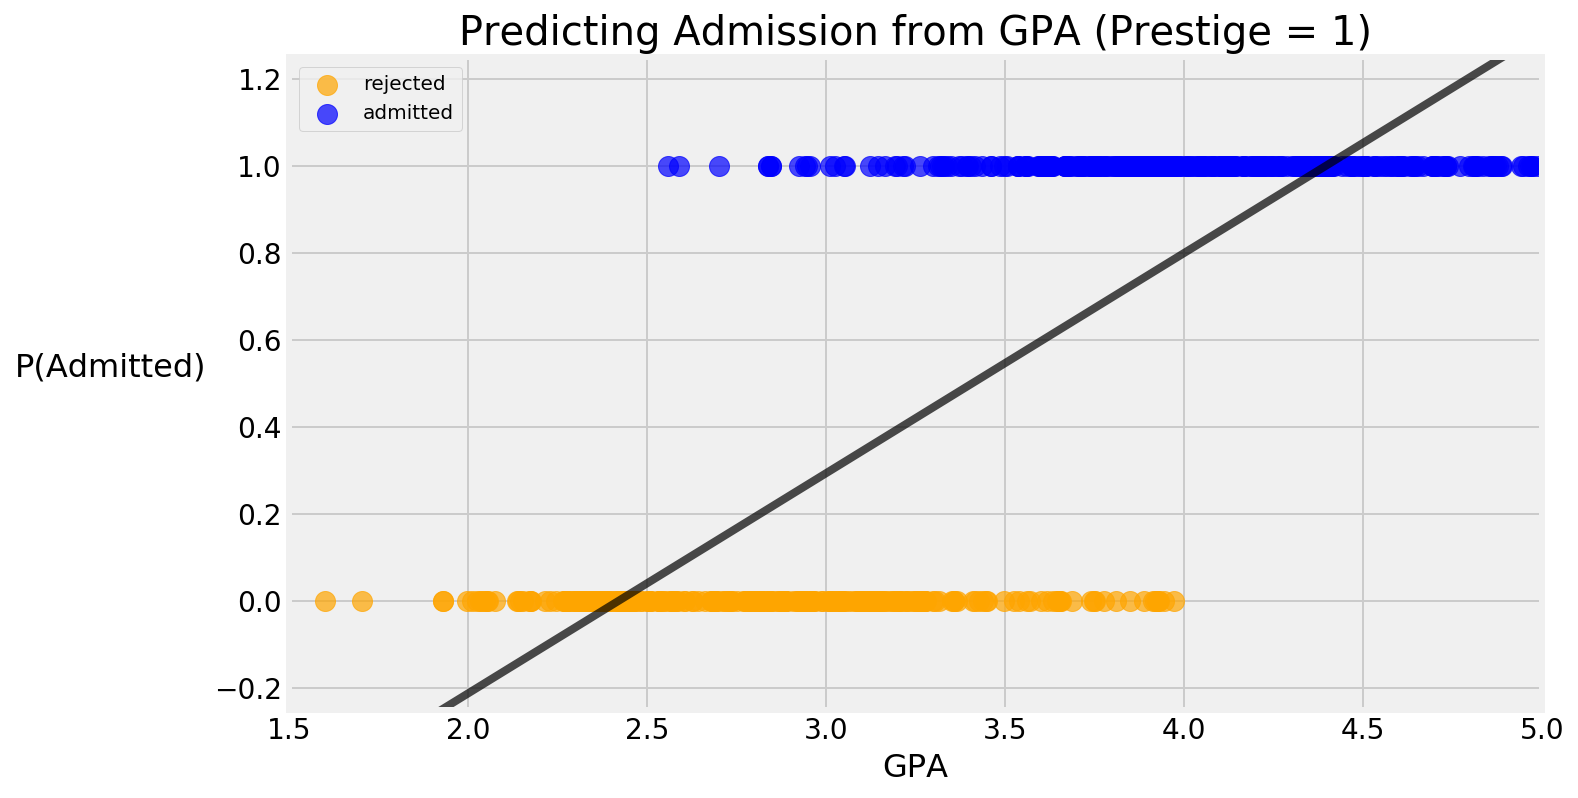

In [9]:
# Create figure.
plt.figure(figsize=(10,6))

# Plot the regression line where gpa predicts admit.
x_vals = np.linspace(1, 5, 300)

# Plot line of best fit
plt.plot(x_vals,
         linmod.predict(x_vals.reshape(-1,1)),
         color='black', alpha=0.7, lw=4)

# Create scatterplot with orange dots for those rejected.
plt.scatter(admit['gpa'][admit['admit'] == 0],
            admit['admit'][admit['admit'] == 0],
            c='orange',
            s=100,
            alpha=0.7,
            label='rejected')

# Create scatterplot with blue dots for those admitted.
plt.scatter(admit['gpa'][admit['admit'] == 1],
            admit['admit'][admit['admit'] == 1],
            c='blue',
            s=100,
            alpha=0.7,
            label='admitted')

# Set labels of axes and title.
plt.ylabel('P(Admitted)', fontsize=16, rotation = 'horizontal', ha = 'right')
plt.yticks(fontsize = 14)
plt.xlabel('GPA', fontsize=16)
plt.xticks(fontsize = 14)
plt.title('Predicting Admission from GPA (Prestige = 1)', fontsize=20)
plt.xlim(1.5, 5)
plt.ylim(-0.25, 1.25)
plt.legend(loc='upper left');

#### **Note:** Unless we predict exactly one value, linear regression will always predict values from $-\infty$ to $+\infty$. This isn't always appropriate in real-world cases!

<a id='pred-binary'></a>

## Predicting a Binary Class

---

In our case we have two classes: `1=admitted` and `0=rejected`.

The logistic regression is still solving for $\hat{Y}$. However, in our binary classification case, $\hat{Y}$ will be the probability of `y` being one of the classes.

### $$\hat{Y} = P(Y = 1)$$

We'll still try to fit a "line" of best fit to this... except it won't be perfectly linear. We need to *guarantee* that the right-hand side of the regression equation will evaluate to a probability. (That is, some number between 0 and 1!)

## The Logit Link Function (advanced)

---

We will use something called a **link function** to effectively "bend" our line of best fit so that it is a curve of best fit that matches the range or set of values in which we're interested.

For logistic regression, that specific link function that transforms ("bends") our line is known as the **logit** link.

### $$\text{logit}\left(P(Y = 1)\right) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p$$

### $$\log\left(\frac{P(Y = 1)}{1 - P(Y = 1)}\right) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p$$

Equivalently, we assume that each independent variable $X_i$ is linearly related to the **log of the odds of success**.

Remember, the purpose of the link function is to bend our line of best fit.
- This is convenient because we can have any values of $X$ inputs that we want, and we'll only ever predict between 0 and 1!
- However, interpreting a one-unit change gets a little harder. (More on this later.)

## Fitting and making predictions with the logistic regression model.

As with linear regression, there are four steps to building a logistic regression model.

1. Instantiate the model.
2. Fit the model.
3. Generate predictions.
4. Evaluate model.

In [10]:
# Step 1: Instantiate our model.
logreg = LogisticRegression()

# Step 2: Fit our model.
logreg.fit(X_train, y_train)

print(f'Logistic Regression Intercept: {logreg.intercept_}')
print(f'Logistic Regression Coefficient: {logreg.coef_}')

Logistic Regression Intercept: [-7.33666042]
Logistic Regression Coefficient: [[2.20134368]]


/Users/gateam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


There are two methods in `sklearn` we will use **a lot** for the rest of this course and beyond:
- `.predict()`
- `.predict_proba()`

In [11]:
# Step 3 (part 1): Generate predicted values.
print(f'Logistic Regression predicted values: {logreg.predict(X_train.head())}')

Logistic Regression predicted values: [0 1 1 1 1]


In [12]:
# Step 3 (part 2): Generate predicted probabilities.
print(f'Logistic Regression predicted probabilities: \n{logreg.predict_proba(X_train.head())}')

Logistic Regression predicted probabilities: 
[[0.79593129 0.20406871]
 [0.25557914 0.74442086]
 [0.19558406 0.80441594]
 [0.25407476 0.74592524]
 [0.28957147 0.71042853]]


<details><summary>How would you interpret the predict_proba() output?</summary>
    
- The first array, [0.79593129 0.20406871], corresponds to the first training observation.
    - This first training observation is predicted to have a 79.59% chance that $Y = 0$ and a 20.41% chance that $Y = 1$.
    - The `.predict()` value for this observation is 0. This is because $P(Y=0) > P(Y=1)$.
- The second array, [0.25557914 0.74442086], corresponds to the second training observation.
    - This second training observation is predicted to have a 25.56% chance that $Y = 0$ and a 74.44% chance that $Y = 1$.
    - The `.predict()` value for this observation is 1. This is because $P(Y=1) > P(Y=0)$.
</details>

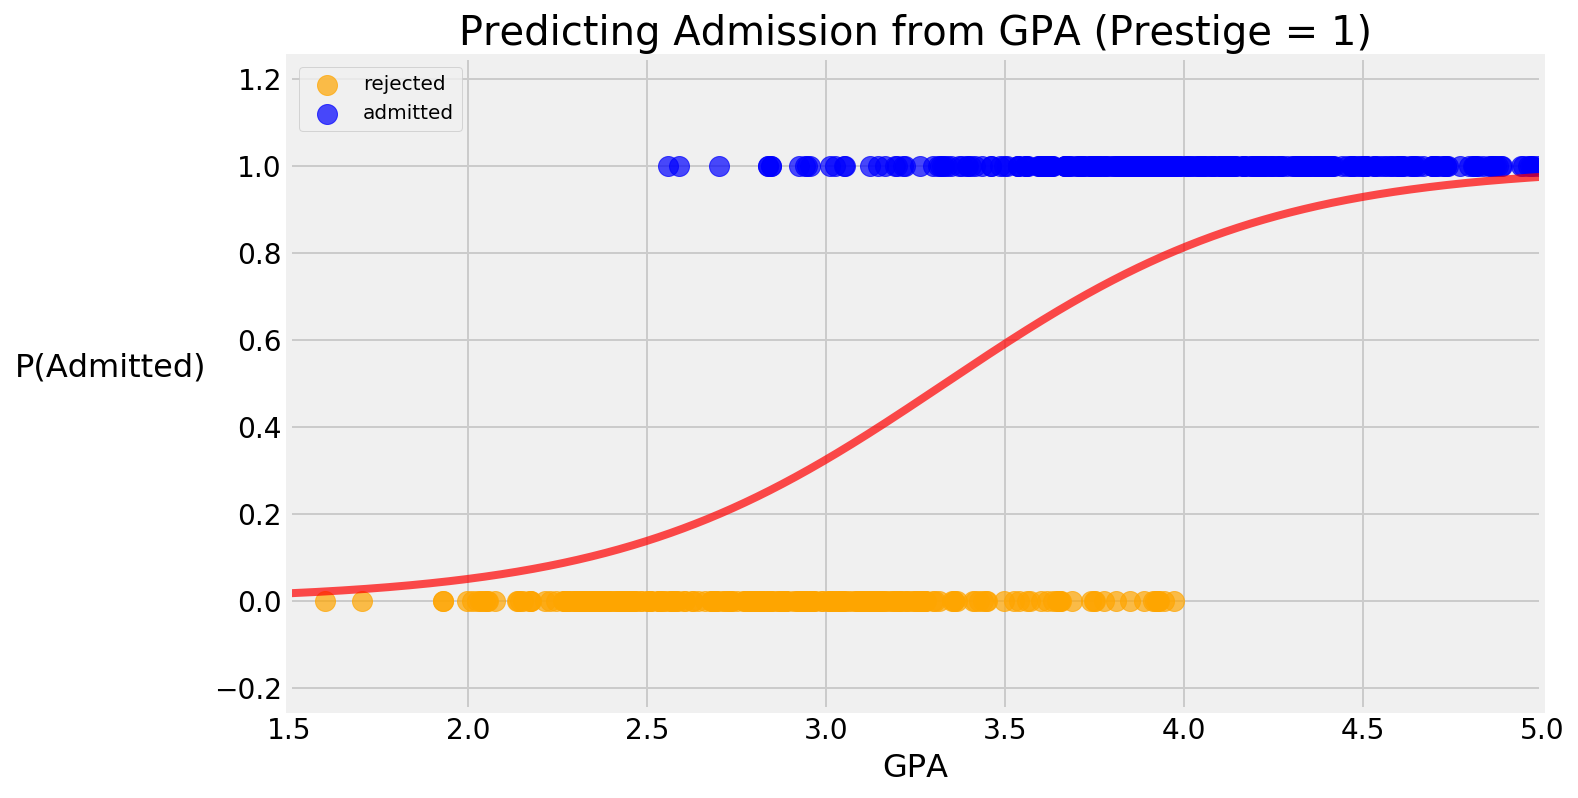

In [13]:
# Visualizing logistic regression probabilities.

# Create figure.
plt.figure(figsize=(10,6))

# Plot the regression line where gpa predicts admit.
x_vals = np.linspace(1, 5, 3000)

# Nicholas Jin - BOS
# Plot line of best fit
plt.plot(x_vals,
         logreg.predict_proba(x_vals.reshape(-1,1))[:,1],
         color='red', alpha=0.7, lw=4)

# Create scatterplot with orange dots for those rejected.
plt.scatter(admit['gpa'][admit['admit'] == 0],
            admit['admit'][admit['admit'] == 0],
            c='orange',
            s=100,
            alpha=0.7,
            label='rejected')

# Create scatterplot with blue dots for those admitted.
plt.scatter(admit['gpa'][admit['admit'] == 1],
            admit['admit'][admit['admit'] == 1],
            c='blue',
            s=100,
            alpha=0.7,
            label='admitted')

# Set labels of axes and title.
plt.ylabel('P(Admitted)', fontsize=16, rotation = 'horizontal', ha = 'right')
plt.yticks(fontsize = 14)
plt.xlabel('GPA', fontsize=16)
plt.xticks(fontsize = 14)
plt.title('Predicting Admission from GPA (Prestige = 1)', fontsize=20)
plt.xlim(1.5, 5)
plt.ylim(-0.25, 1.25)
plt.legend(loc='upper left');

In [14]:
# Step 4: Evaluate model.
print(f'Logistic Regression Accuracy Score: {logreg.score(X_test, y_test)}')

Logistic Regression Accuracy Score: 0.8811881188118812


By default, the `.score()` method for classification models gives us the accuracy score.

$$
\begin{eqnarray*}
\text{Accuracy} = \frac{\text{number of correct predictions}}{\text{number of total predictions}}
\end{eqnarray*}
$$

<details><summary>Remind me: what does .score() tell me for a regression model?</summary>
    
- The $R^2$ score.
- Remember that $R^2$ is the proportion of variance in our $Y$ values that are explained by our model.
</details>

### Using the log-odds —the natural logarithm of the odds.

The combination of converting the "probability of success" to "odds of success," then taking the logarithm of that is called the **logit link function**.

### $$\text{logit}\big(P(Y=1)\big) = \log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p$$

We've bent our line how we want... but how do we interpret our coefficients?

### Odds

Probabilities and odds represent the same thing in different ways. The odds for probability **p** is defined as:

### $$\text{odds}(p) = \frac{p}{1-p}$$

The odds of a probability is a measure of how many times as likely an event is to happen than it is to not happen.

**Example**: Suppose I'm looking at the probability and odds of a specific horse, "Secretariat," winning a race.

- When **`p = 0.5`**: **`odds = 1`**
    - The horse Secretariat is as likely to win as it is to lose.
- When **`p = 0.75`**: **`odds = 3`**
    - The horse Secretariat is three times as likely to win as it is to lose.
- When **`p = 0.40`**: **`odds = 0.666..`**
   - The horse Secretariat is two-thirds as likely to win as it is to lose.

In [16]:
# Define a function called odds to calculate the odds of success.
def odds(p):
    return (p / (1 - p))

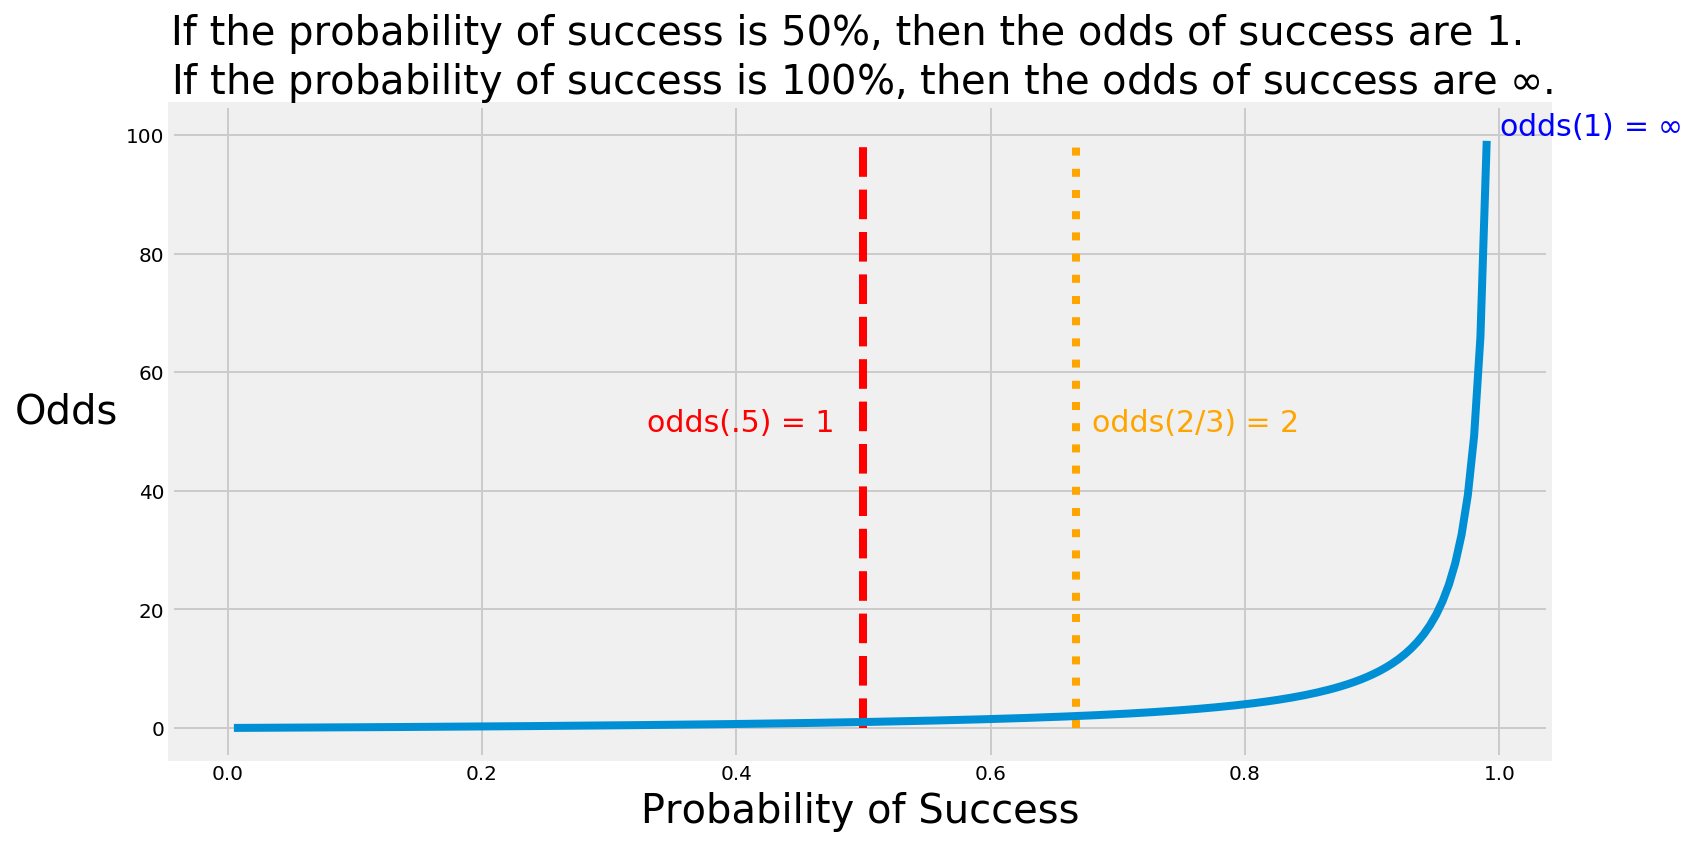

In [17]:
# Plot a range of probabilities.
probabilities = np.linspace(0.005, .99, 200)

# Generate list of odds.
odds_list = [odds(proba) for proba in probabilities]

# Create figure.
plt.figure(figsize=(11,6))

# Plot blue line for odds as probability goes from 0.5% to 99%.
plt.plot(probabilities,
         odds_list)

# Plot red dashed line to visualize odds when probability is 50%.
plt.vlines(.5, 0, 100, linestyles="dashed", color='red')
plt.text(.33, 50, "odds(.5) = 1", fontsize=15, color = 'red')

# Plot orange dotted line to visualize odds when probability is 66.67%.
plt.vlines(.6667, 0, 100, linestyles="dotted", color='orange')
plt.text(.68, 50, "odds(2/3) = 2", fontsize=15, color='orange')

# Annotate blue line when probability is 100%.
plt.text(1, 100, "odds(1) = $\infty$", fontsize=15, color='blue')

# Add axis labels.
plt.xlabel('Probability of Success', fontsize = 20)
plt.ylabel('Odds',
           fontsize = 20,
           rotation = 'horizontal',
           ha = 'right')

# Make title.
plt.title("If the probability of success is 50%, then the odds of success are 1.\nIf the probability of success is 100%, then the odds of success are $\infty$.",
          ha = 'left',
          position = (0,1),
          fontsize=20);

## Interpreting a one-unit change in $X_i$.

$$\log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg) = \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p$$

Given this model, a one-unit change in $X_i$ implies a $\beta_i$ unit change in the log odds of success.

**This is annoying**.

We often convert log-odds back to "regular odds" when interpreting our coefficient... our mind understands odds better than the log of odds.

**(BONUS)** So, let's get rid of the log on the left-hand side. Mathematically, we do this by "exponentiating" each side.
$$
\begin{eqnarray*}
\log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg) &=& \beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p \\
\Rightarrow e^{\Bigg(\log\bigg(\frac{P(Y=1)}{1-P(Y=1)}\bigg)\Bigg)} &=& e^{\Bigg(\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p\Bigg)} \\
\Rightarrow \frac{P(Y=1)}{1-P(Y=1)} &=& e^{\Bigg(\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p\Bigg)} \\
\end{eqnarray*}
$$

**Interpretation**: A one-unit change in $X_i$ means that success is $e^{\beta_i}$ times as likely.

<details><summary> I want to interpret the coefficient $\hat{\beta}_1$ for my logistic regression model. How would I interpret this coefficient?</summary>
    
- Our model is that $\log\bigg(\frac{P(admit=1)}{1-P(admit=1)}\bigg) = \beta_0 + \beta_1\text{GPA}$.
- As GPA increases by 1, the log-odds of someone being admitted increases by 2.20.
- As GPA increases by 1, someone is $e^{2.20}$ times as likely to be admitted.
- As GPA increases by 1, someone is about 9.04 times as likely to be admitted to grad school.
</details>

> Hint: Use the [np.exp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html) function.

In [18]:
print(f'Logistic Regression Coefficient: {logreg.coef_}')

Logistic Regression Coefficient: [[2.20134368]]


In [19]:
# Use np.exp() to exponentiate the coefficient.
np.exp(logreg.coef_)

array([[9.03714842]])

## Beyond binary classification problems.

Today, we looked at a binary classification problem: was somebody admitted, or not? Many of our classification problems will be binary. Even if the problem isn't binary, we can always force it to be binary. (i.e. Did the stock price increase or decrease?)

However, some of our classification problems won't be binary. You'll see an example of this in a later lesson!

## Conclusion

The goal of logistic regression is to find the best-fitting model to describe the relationship between a binary outcome and a set of independent variables.

Logistic regression generates the coefficients of a formula to predict a logit transformation of the probability that the characteristic of interest is present.

## Interview Questions

<details><summary>What is the difference between a classification and a regression problem?</summary>
    
- A classification problem has a discrete $Y$ variable. A regression problem has a continuous $Y$ variable.
</details>

<details><summary>What are some of the benefits of logistic regression as a classifier?</summary>

(Answers may vary; this is not an exhaustive list!)
- Logistic regression is a classification algorithm that shares similar properties to linear regression.
- The coefficients in a logistic regression model are interpretable. (They represent the change in log-odds caused by the input variables.)
- Logistic regression is a very fast model to fit and generate predictions from.
- It is by far the most common classification algorithm.

**Note**: The original interview question was "If you're comparing decision trees and logistic regression, what are the pros and cons of each?"
</details>

## (BONUS) Solving for the Beta Coefficients

Logistic regression minimizes the "deviance," which is similar to the residual sum of squares in linear regression, but is a more general form. 

**There's no closed-form solution to the beta coefficients like in linear regression, and the betas are found through optimization procedures.**
- We can't just do $\hat{\beta} = (X^TX)^{-1}X^Ty$ like we can in linear regression!

If you're particularly interested in the math, here are two helpful resources:
- [A good blog post](http://www.win-vector.com/blog/2011/09/the-simpler-derivation-of-logistic-regression/) on the logistic regression beta coefficient derivation.
- [This paper](https://www.stat.cmu.edu/~cshalizi/402/lectures/14-logistic-regression/lecture-14.pdf) is also a good reference.

## (BONUS) The Logistic Function

The inverse function of the logit is called the **logistic function**. 

By inverting the logit, we can have the right side of our regression equation solve explicitly for $P(Y = 1)$:

### $$P(Y=1) = logit^{-1}\left(\beta_0 + \sum_{j}^p\beta_jX_j\right)$$

Where:

### $$logit^{-1}(a) = logistic(a) = \frac{e^{a}}{e^{a} + 1}$$ 

Giving us:

### $$P(Y=1) = \frac{e^{\left(\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p\right)}}{e^{\left(\beta_0 + \beta_1X_1 + \beta_2X_2 + \cdots + \beta_pX_p\right)}+1}$$